# Project Urinary biomarkers to predict pancreatic cancer

## Table of Contents:

* [Project description](#description)
* [Description of the data](#data)
* [Data Reading and Data Cleaning](#read)
* [EDA](#EDA)    
* [Prepare data for machine learning](#Prepare)
    * [One-Hot Encoding](#One-HotEncoding)
    * [Changing from 3 labels to a binary label](#label)
    * [Spliting the Data](#spliting)
* [Machine learning models](#models)
    * [Baseline model](#baseline)
    * [Catboost Classifier](#Catboost)
    * [Use synthetic data to improve the model](#synthetic)
* [Testing](#Testing)
* [Conclusion](#Conclusion)

## Project description <a class="anchor" id="description"></a>

Pancreatic cancer is an extremely deadly type of cancer. Once diagnosed, the five-year survival rate is less than 10%. However, if pancreatic cancer is caught early, the odds of surviving are much better. Unfortunately, many cases of pancreatic cancer show no symptoms until the cancer has spread throughout the body. A diagnostic test to identify people with pancreatic cancer could be enormously helpful.

In a paper (https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489) by Silvana Debernardi and colleagues, published this year in the journal PLOS Medicine, a multi-national team of researchers sought to develop an accurate diagnostic test for the most common type of pancreatic cancer, called pancreatic ductal adenocarcinoma or PDAC. They gathered a series of biomarkers from the urine of three groups of patients:
* Healthy controls
* Patients with non-cancerous pancreatic conditions, like chronic pancreatitis
* Patients with pancreatic ductal adenocarcinoma
When possible, these patients were age- and sex-matched. The goal was to develop an accurate way to identify patients with pancreatic cancer.

The goal, is to predict the presence of disease before it's diagnosed

### Description of the data  <a class="anchor" id="data"></a>

The key features are four urinary biomarkers: creatinine, LYVE1, REG1B, and TFF1.

Creatinine is a protein that is often used as an indicator of kidney function.
* YVLE1 is lymphatic vessel endothelial hyaluronan receptor 1, a protein that may play a role in tumor metastasis
* REG1B is a protein that may be associated with pancreas regeneration
* TFF1 is trefoil factor 1, which may be related to regeneration and repair of the urinary tract

Age and sex, both included in the dataset, may also play a role in who gets pancreatic cancer. The dataset includes a few other biomarkers as well, but these were not measured in all patients (they were collected partly to measure how various blood biomarkers compared to urine biomarkers).

## Data Reading and Data Cleaning<a class="anchor" id="read"></a>

In [1]:
# set enviorment 
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from numpy.random import RandomState

import time

from catboost import Pool, cv

import sklearn.metrics as metrics
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#synthatic model datgenerators 
from sdv.lite import TabularPreset
from sdv.tabular import TVAE
from sdv.tabular import GaussianCopula
from sdv.tabular import CopulaGAN
from sdv.tabular import CTGAN


from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings('ignore')

In [2]:
#openfiles from directory
try:
    df = pd.read_csv('Debernardi et al 2020 data.csv')
except:
    print("Something went wrong when opening the file")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [4]:
#checking for missing values
report = df.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
stage,391,0.66
benign_sample_diagnosis,382,0.65
REG1A,284,0.48
plasma_CA19_9,240,0.41
sample_id,0,0.00
patient_cohort,0,0.00
sample_origin,0,0.00
age,0,0.00
sex,0,0.00
diagnosis,0,0.00


In [5]:
print("duplicates number: {}".format(df.duplicated().sum()))

duplicates number: 0


In [6]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


## EDA<a class="anchor" id="EDA"></a>

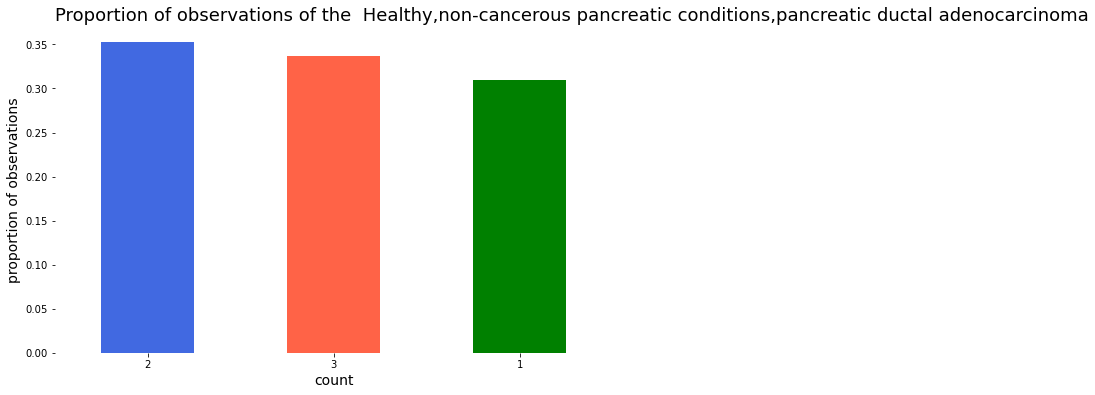

In [7]:
# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of observation of each class
diagnosis = df['diagnosis'].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
diagnosis.plot(kind='bar', 
                   ax=ax,
                   color=['royalblue','tomato','green'])

# set title and labels
ax.set_title('Proportion of observations of the  Healthy,non-cancerous pancreatic conditions,pancreatic ductal adenocarcinoma',
             fontsize=18, loc='left')
ax.set_xlabel('count',
              fontsize=14)
ax.set_ylabel('proportion of observations',
              fontsize=14)
ax.tick_params(rotation='auto')

# eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>
183 control samples, 208 benign hepatobiliary disease samples (of which 119 were chronic pancreatitis), and 199 pancreatic ductal adenocarcinoma samples (102 stage I–II and 97 stage III–IV); 50.7% were from female individuals.

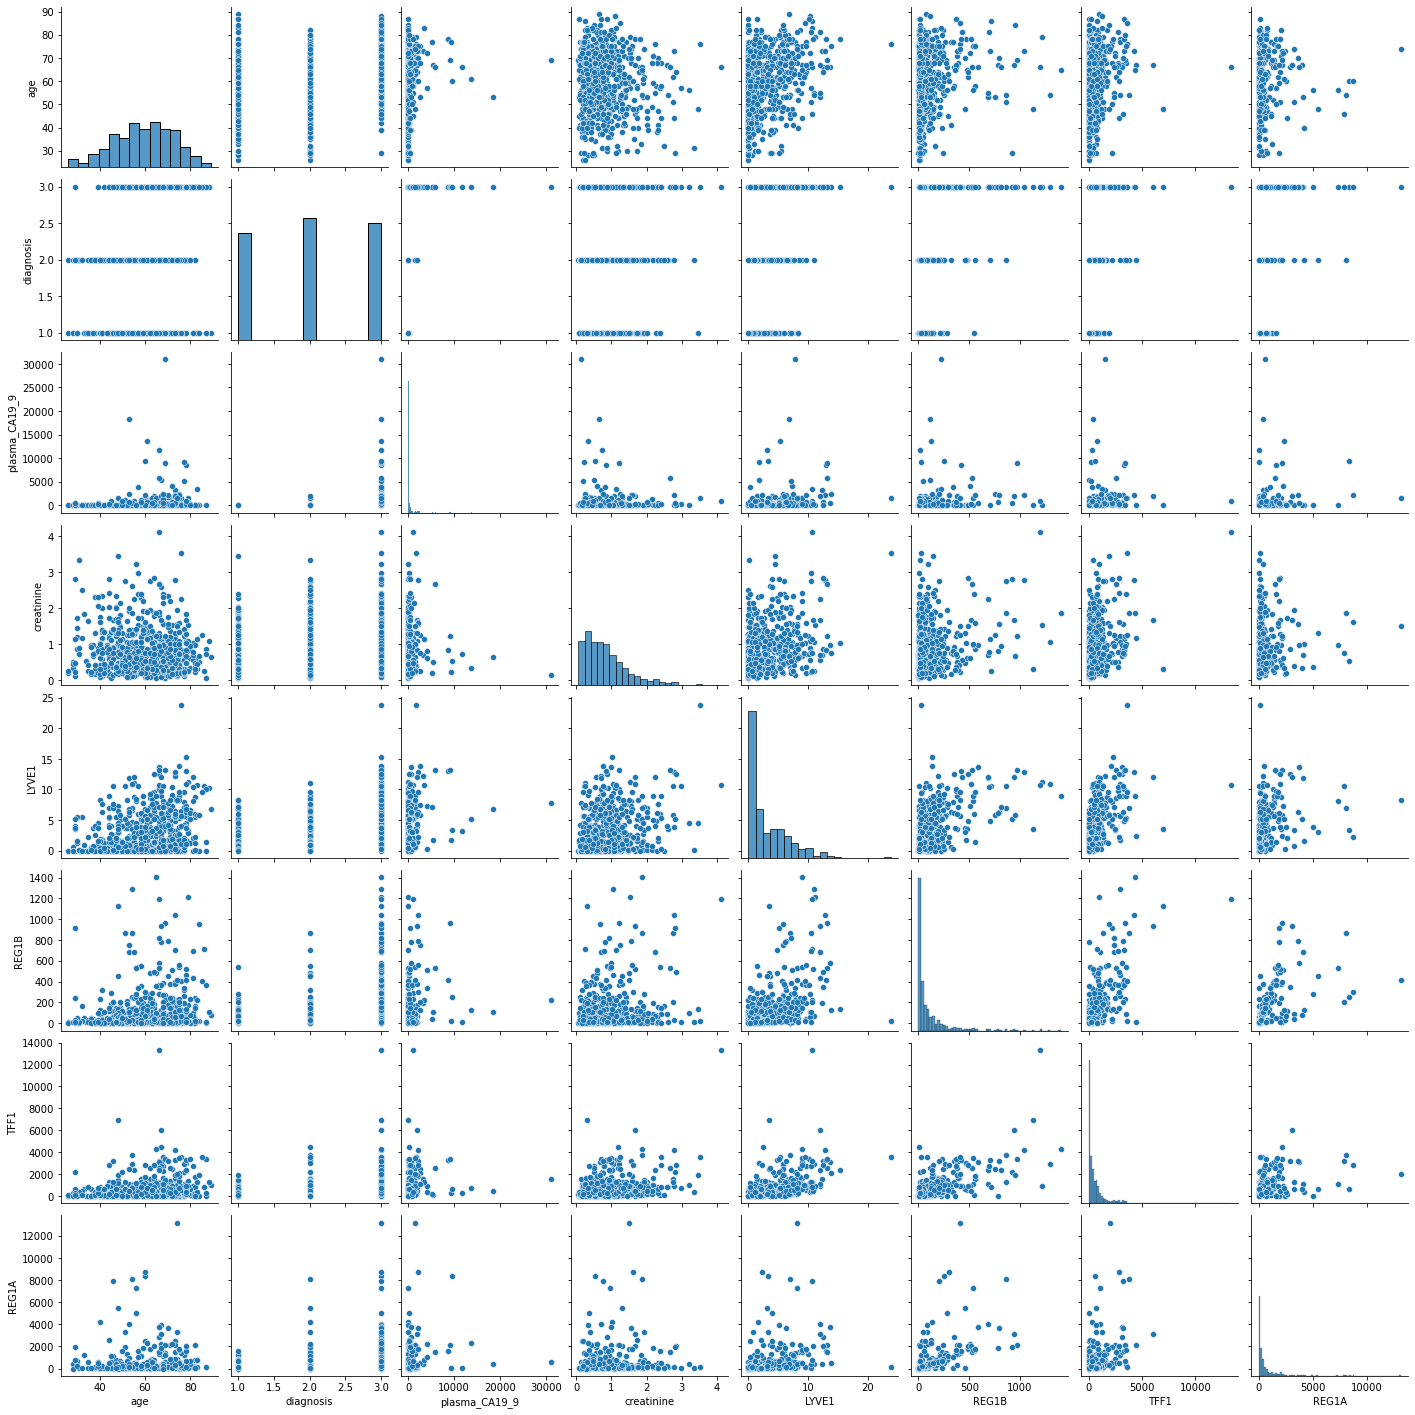

In [8]:
sns.pairplot(df)
plt.show()

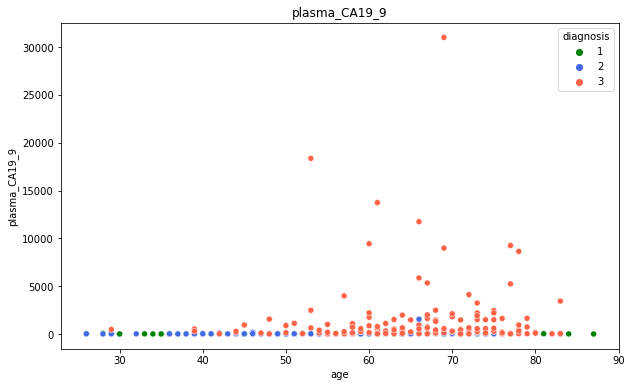

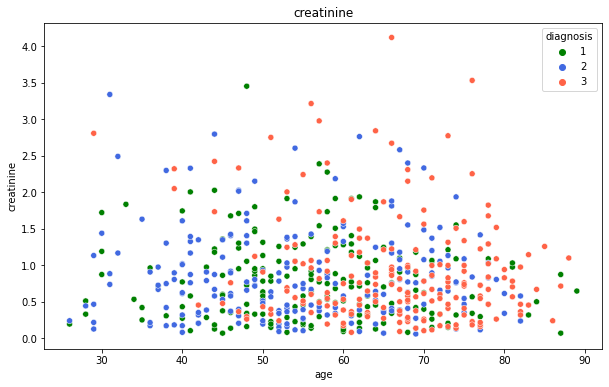

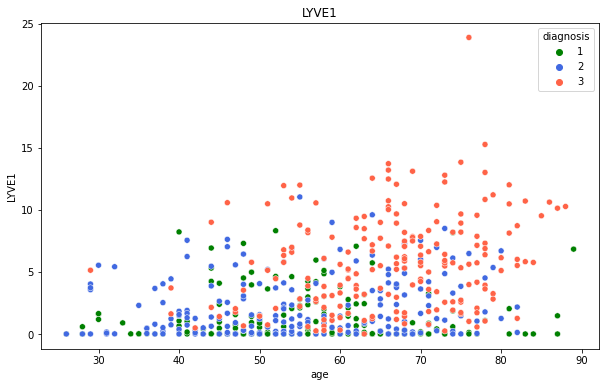

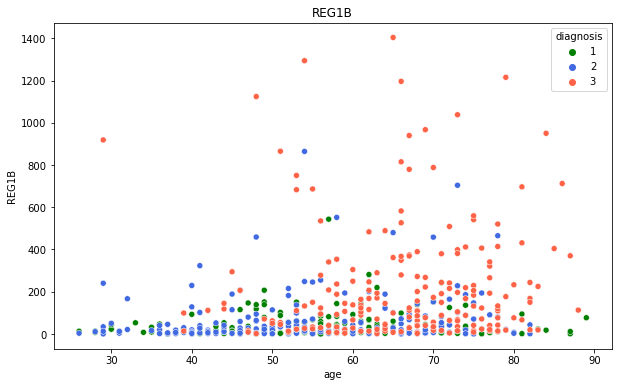

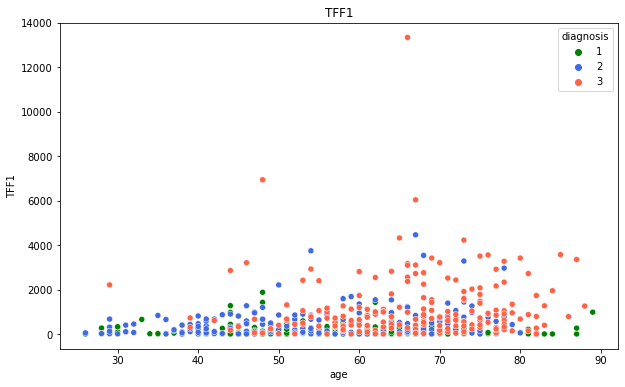

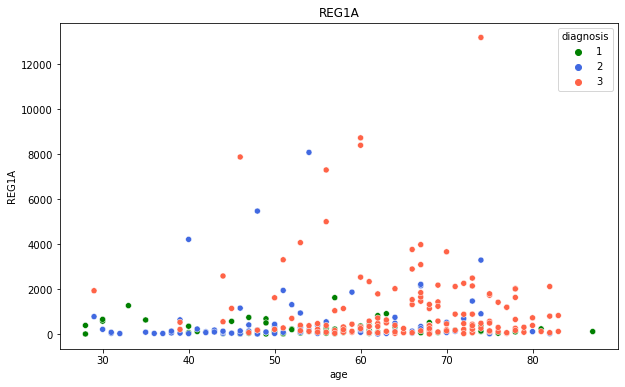

In [9]:
markers = ['plasma_CA19_9' ,'creatinine' ,'LYVE1' ,'REG1B' ,'TFF1' ,'REG1A' ]
for marker in markers:
    # create a figure
    fig = plt.figure(figsize=(10, 6)) 
    ax = fig.add_subplot(111)
    # set title and labels
    ax.set_title(marker)
    
    sns.scatterplot(data = df, x= 'age', y=marker,hue='diagnosis', palette=['green','royalblue','tomato'])
    plt.show()

In [10]:
df.query('plasma_CA19_9 > 30000 or LYVE1>20 or TFF1>12000 or REG1A>12000')

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
427,S399,Cohort1,LIV,69,M,3,IIB,NaN,31000.0,0.13572,7.786741,222.366130,1541.648682,572.931
487,S572,Cohort2,BPTB,66,F,3,IIB,NaN,936.0,4.11684,10.733280,1195.972000,13344.300000,NaN
498,S400,Cohort1,LIV,76,M,3,III,NaN,1621.0,3.52872,23.890323,23.156637,3555.722632,107.152
589,S590,Cohort1,BPTB,74,M,3,IV,NaN,1488.0,1.50423,8.200958,411.938275,2021.321078,13200.000


<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>
As the outliers differ in different markers, and they represent cancer daignosed patent (lable 3), I've decided not to exclude them. 

## Prepare data for machine learning<a class="anchor" id="Prepare"></a>


<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>

    
* the stages are present only for diagnosed patiants - data leakage
* also the benign_sample_diagnosis- data leakage
* drop sample id and patient chorot


In [11]:
df1 = df.copy().drop(['stage','benign_sample_diagnosis','sample_id','patient_cohort','sample_origin'],axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   sex            590 non-null    object 
 2   diagnosis      590 non-null    int64  
 3   plasma_CA19_9  350 non-null    float64
 4   creatinine     590 non-null    float64
 5   LYVE1          590 non-null    float64
 6   REG1B          590 non-null    float64
 7   TFF1           590 non-null    float64
 8   REG1A          306 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 41.6+ KB


### One-Hot Encoding<a class="anchor" id="One-HotEncoding"></a>

In [12]:
#One-Hot Encoding for sex feature
df2 = pd.get_dummies(df1.copy(), columns = ['sex'],drop_first=True)
df2.head()

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,sex_M
0,33,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000,0
1,81,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407,0
2,51,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN,1
3,61,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN,1
4,62,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN,1


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   diagnosis      590 non-null    int64  
 2   plasma_CA19_9  350 non-null    float64
 3   creatinine     590 non-null    float64
 4   LYVE1          590 non-null    float64
 5   REG1B          590 non-null    float64
 6   TFF1           590 non-null    float64
 7   REG1A          306 non-null    float64
 8   sex_M          590 non-null    uint8  
dtypes: float64(6), int64(2), uint8(1)
memory usage: 37.6 KB


In [14]:
#cahnge data type from uint8  to int64
df2['sex_M'] =df2['sex_M'].astype('int64') 

In [15]:
df2.describe()

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,sex_M
count,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000,590.000000
mean,59.079661,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222,0.493220
std,13.109520,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724,0.500378
min,26.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000,0.000000
25%,50.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000,0.000000
50%,60.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500,0.000000
75%,69.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000,1.000000
max,89.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000,1.000000


### changing from 3 labels to a binary label<a class="anchor" id="label"></a>

In [16]:

# diagnosis will be healthy (1 to 0) and the condition: pancreatic cancer + non-cancerous pancreas condition (2 and 3 to 1)
df2['two_lable_diagnosis'] = np.where(df2['diagnosis'] ==1,0,1)

In [17]:
df2.two_lable_diagnosis.value_counts()

1    407
0    183
Name: two_lable_diagnosis, dtype: int64

In [18]:
assert (len(df2[df2['diagnosis'] ==2])+len(df2[df2['diagnosis'] ==3])) == len(df2[df2['two_lable_diagnosis'] ==1])

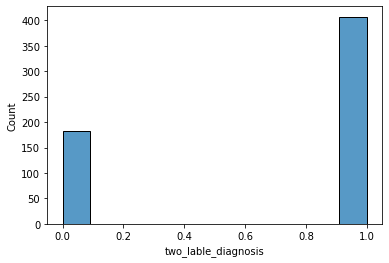

In [19]:
sns.histplot(data=df2.two_lable_diagnosis)
plt.title
plt.show()

In [20]:
df2  = df2.drop('diagnosis',axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  590 non-null    int64  
 1   plasma_CA19_9        350 non-null    float64
 2   creatinine           590 non-null    float64
 3   LYVE1                590 non-null    float64
 4   REG1B                590 non-null    float64
 5   TFF1                 590 non-null    float64
 6   REG1A                306 non-null    float64
 7   sex_M                590 non-null    int64  
 8   two_lable_diagnosis  590 non-null    int32  
dtypes: float64(6), int32(1), int64(2)
memory usage: 39.3 KB


### spliting the data<a class="anchor" id="spliting"></a>

In [30]:
### Split the data into three sets <a class="anchor" id="split"></a>
df_train_and_valid, df_test = train_test_split(df2, test_size=0.20, random_state=12345)
df_train, df_valid = train_test_split(df_train_and_valid, test_size=0.25, random_state=12345)


In [31]:
def make_feature_target(data_set):
    #create features(X) and target(y) from splited datasets
    features = data_set.copy().drop('two_lable_diagnosis',axis=1)
    target = data_set['two_lable_diagnosis']
    return features,target

In [32]:
# use make_feature_target for all datasets

features_train, target_train = make_feature_target(df_train)
#print shape of feature and target for train datasets
print('features_train shape: ',features_train.shape ,'target_train shape: ',target_train.shape)

features_valid, target_valid =make_feature_target(df_valid)
#print shape of feature and target for validation datasets
print('features_valid shape: ',features_valid.shape ,'target_valid shape: ',target_valid.shape)

features_test , target_test = make_feature_target(df_test)
#print shape of feature and test for train datasets
print('features_test shape: ',features_test.shape ,'target_test shape: ',target_test.shape)


features_train shape:  (354, 8) target_train shape:  (354,)
features_valid shape:  (118, 8) target_valid shape:  (118,)
features_test shape:  (118, 8) target_test shape:  (118,)


## machine learning models<a class="anchor" id="models"></a>

### Baseline model <a class="anchor" id="baseline"></a>

First I'm going to test the baseline model with the recall score. In cancer research it is preferable to use recall because not “capturing” even one case of cancer could result in death, the models should emphasize the recall score. It is far preferable to not “miss” anyone with cancer even if that means “flagging” some patients as having cancer that does not have the disease.

for more explanation please see this post by Giovanni Rosati
https://towardsdatascience.com/precision-recall-and-predicting-cervical-cancer-with-machine-learning-367221e70538

and 
https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
by Koo Ping Shung

#### Catboost Classifier<a class="anchor" id="Catboost"></a>

I use the Catboost classifier which can handle missing values. 


##### Finding Catboost Classifier baseline parameters<a class="anchor" id="Catboost"></a>

In [24]:
#create dict for values 
train_recalls = {}
valid_recalls = {}
#create list for depth parameter
depths = np.arange(1, 17)
for depth in depths:
    #set model
    model_cbc= CatBoostClassifier(depth =depth,silent=True)
    #fit model
    model_cbc.fit(features_train, target_train)
    #creat prediction and recall score for training set
    predictions_train = model_cbc.predict(features_train)
    train_recalls[depth] = recall_score(predictions_train, target_train)
    #creat prediction and recall score for validation set
    predictions_valid = model_cbc.predict(features_valid)
    valid_recalls[depth] = recall_score(predictions_valid,target_valid)

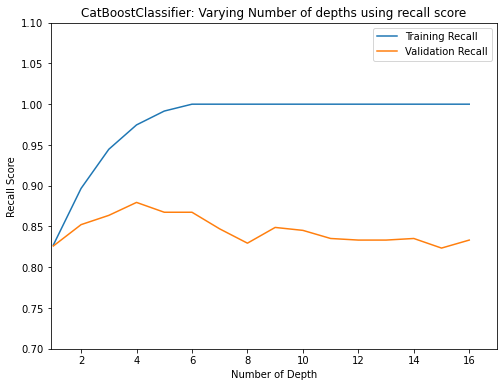

In [142]:
plt.figure(figsize=(8, 6))
plt.title("CatBoostClassifier: Varying Number of depths using recall score")
#plot train recall score
plt.plot(depths, train_recalls.values(), label="Training Recall")
#plot Validation recall score
plt.plot(depths, valid_recalls.values(), label="Validation Recall")
# set limits for axises 
plt.ylim(0.7,1.1)
plt.xlim(0.9,17)
plt.legend()
# set labels for axises 
plt.xlabel("Number of Depth")
plt.ylabel("Recall Score")
plt.show()

In [67]:
#create dict for values 
train_f1 = {}
valid_f1 = {}
#create list for depth parameter
depths = np.arange(1, 17)
for depth in depths:
    #set model
    model_cbc= CatBoostClassifier(depth =depth,silent=True)
    #fit model
    model_cbc.fit(features_train, target_train)
    #creat prediction and recall score for training set
    predictions_train = model_cbc.predict(features_train)
    train_f1[depth] = f1_score(predictions_train, target_train)
    #creat prediction and recall score for validation set
    predictions_valid = model_cbc.predict(features_valid)
    valid_f1[depth] = f1_score(predictions_valid,target_valid)

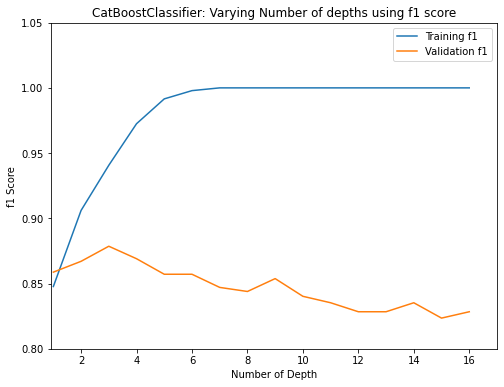

In [150]:
plt.figure(figsize=(8, 6))
plt.title("CatBoostClassifier: Varying Number of depths using f1 score")
#plot train recall score
plt.plot(depths, train_f1.values(), label="Training f1")
#plot Validation recall score
plt.plot(depths, valid_f1.values(), label="Validation f1")
# set limits for axises 
plt.ylim(0.8,1.05)
plt.xlim(0.9,17)
plt.legend()
# set labels for axises 
plt.xlabel("Number of Depth")
plt.ylabel("f1 Score")
plt.show()

In [26]:
#creat dict for values 
train_recalls_2 = {}
valid_recalls_2 = {}
#create list for iterations parameter
iterations = np.arange(100,1100,100)

for iterat in iterations:
    #set model
    model_cbc= CatBoostClassifier(iterations=iterat,depth =4,silent=True)
    #fit model
    model_cbc.fit(features_train, target_train)
    #creat prediction and recall score for training set
    predictions_train = model_cbc.predict(features_train)
    train_recalls_2[iterat] = f1_score(predictions_train, target_train)
    #creat prediction and recall score for validation set
    predictions_valid = model_cbc.predict(features_valid)
    valid_recalls_2[iterat] = f1_score(predictions_valid,target_valid)

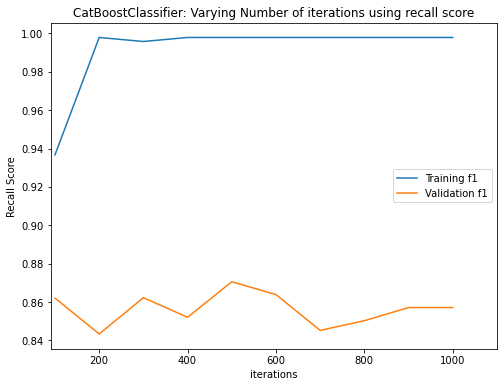

In [151]:
plt.figure(figsize=(8, 6))
plt.title("CatBoostClassifier: Varying Number of iterations using recall score")
#plot train recall score
plt.plot(iterations, train_recalls_2.values(), label="Training f1")
#plot Validation recall score
plt.plot(iterations, valid_recalls_2.values(), label="Validation f1")
# set limits for axises
#plt.ylim(0.8,1.05)
plt.xlim(90,1100)

plt.legend()
# set labels for axises 
plt.xlabel("iterations")
plt.ylabel("Recall Score")
plt.show()

In [71]:
#creat dict for values 
train_f1_2 = {}
valid_f1_2 = {}
#create list for iterations parameter
iterations = np.arange(100,1100,100)

for iterat in iterations:
    #set model
    model_cbc= CatBoostClassifier(iterations=iterat,depth =4,silent=True)
    #fit model
    model_cbc.fit(features_train, target_train)
    #creat prediction and recall score for training set
    predictions_train = model_cbc.predict(features_train)
    train_f1_2[iterat] = f1_score(predictions_train, target_train)
    #creat prediction and recall score for validation set
    predictions_valid = model_cbc.predict(features_valid)
    valid_f1_2[iterat] = f1_score(predictions_valid,target_valid)

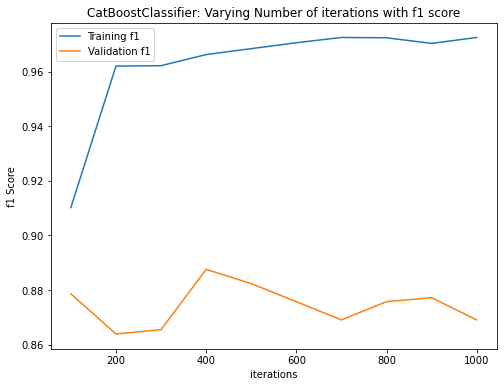

In [145]:
plt.figure(figsize=(8, 6))
plt.title("CatBoostClassifier: Varying Number of iterations with f1 score")
#plot train recall score
plt.plot(iterations, train_f1_2.values(), label="Training f1")
#plot Validation recall score
plt.plot(iterations, valid_f1_2.values(), label="Validation f1")
# set limits for axises 
#plt.ylim(0.8,1.05)
#plt.xlim(90,1100)
plt.legend()
# set labels for axises 
plt.xlabel("iterations")
plt.ylabel("f1 Score")
plt.show()

<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>
the parameters will be depth=3 and iterations=400

In [136]:
def evaluate_model(X_train,y_train,X_test,y_test,name,model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
#validation of the data
    print(f'recall_score {name} set:',recall_score(y_test, predictions))
    print(f'f1_score {name} set:',f1_score(y_test, predictions))

In [197]:
evaluate_model(features_train,target_train,features_train,target_train,'train',CatBoostClassifier(depth=3,iterations=400,silent=True))


recall_score train set: 0.9324894514767933
f1_score train set: 0.9384288747346072


In [198]:
evaluate_model(features_train,target_train,features_valid,target_valid,'valid',CatBoostClassifier(depth =3,iterations=400,silent=True))


recall_score valid set: 0.8823529411764706
f1_score valid set: 0.872093023255814


### Use synthetic data to improve the model <a class="anchor" id="synthetic"></a>

The Synthetic Data Vault (SDV) is a Synthetic Data Generation ecosystem of libraries that allows users to easily learn single-table, multi-table and timeseries datasets to later on generate new Synthetic Data that has the same format and statistical properties as the original dataset.
https://sdv.dev/SDV/index.html

I'll test different SDV models with my training set and find which one can improve my baseline model the best

In [36]:
#Function that test the syntatic models with recall score 
def eavaluate_synth(name,model_ml,model_synth,original_data,X_test,y_test):
    #creat list for recall score
    recall = []    
    f1 = []
    #creat DataFrame for recall score and syntactic data length
    results = pd.DataFrame(columns=['recall','f1'], index=list(range(0,1050,50)))
    
    #training and calculating for the first recall value
    X_train,y_train = make_feature_target(original_data)

    model_ml.fit(X_train,y_train)
    predictions = model_ml.predict(X_test)
    
    recall.append(recall_score(y_test, predictions)) 
    f1.append(f1_score(y_test, predictions))
    
    #fitting the synthetic data model
    model_synth = model_synth
    model_synth.fit(original_data)
    #seting the baseline
    new_df=original_data.copy()
    
    #adding score for more synthetic data with 50 rows jump
    while len(new_df) < (1000+len(original_data)):
        
        #making the synthetic data
        synth_data = model_synth.sample(50)
        
        #appending the synthetic data to the original data set
        new_df= new_df.append(synth_data, ignore_index=True)
        
        #spliting the new data
        X_synth,y_synth = make_feature_target(new_df)
        
        ##training and calculating for the recall value for "bigger by 50" dataset
        model_ml.fit(X_synth,y_synth)
        predictions = model_ml.predict(X_test)

        recall.append(recall_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions))
    results['recall'] = recall
    results['f1'] = f1
    #make a line plot for recall score for added synthetic data wit 50 rows jump
    sns.lineplot(data=results)
    #sns.lineplot(data=results, x=list(range(0,1050,50)), y='recall')
    #sns.lineplot(data=results, x=list(range(0,1050,50)), y='f1')
    plt.title(name)
    plt.ylabel("Scores")
    plt.show()

    #return max result and the basline result
    return new_df,results

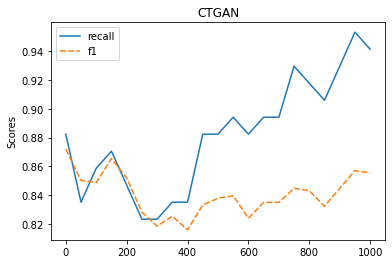

In [199]:
CTGAN_data_Set,CTGAN_results= eavaluate_synth('CTGAN',CatBoostClassifier(depth =3,iterations=400,silent=True),CTGAN(),df_train,features_valid,target_valid)

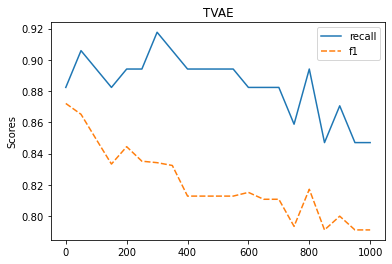

In [200]:
TVAE_data_Set,TVAE_results = eavaluate_synth('TVAE',CatBoostClassifier(depth =3,iterations=400,silent=True),TVAE(),df_train,features_valid,target_valid)

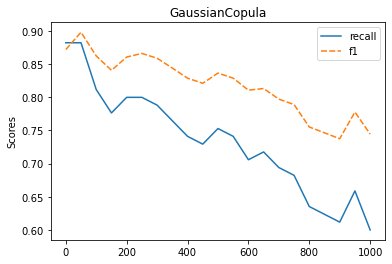

In [201]:
GaussianCopula_data_Set ,GaussianCopula_results= eavaluate_synth('GaussianCopula',CatBoostClassifier(depth =3,iterations=400,silent=True),GaussianCopula(),df_train,features_valid,target_valid)

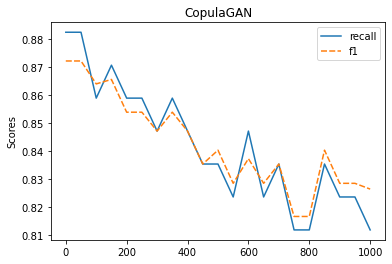

In [202]:
CopulaGAN_data_Set,CopulaGAN_results = eavaluate_synth('CopulaGAN',CatBoostClassifier(depth =3,iterations=400,silent=True),CopulaGAN(),df_train,features_valid,target_valid)

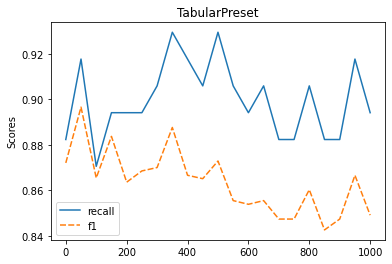

In [203]:
TabularPreset_data_Set,TabularPreset_results = eavaluate_synth('TabularPreset',CatBoostClassifier(depth =3,iterations=400,silent=True),TabularPreset(name='FAST_ML'),df_train,features_valid,target_valid)

In [204]:
def best_results(name,results):
    print(name,'best recall')
    print(results[results['recall'] == results.recall.max()])
    print(name,'best f1')
    print(results[results['f1'] == results.f1.max()])

In [214]:
print('base line validation score')
evaluate_model(features_train,target_train,features_valid,target_valid,'valid',CatBoostClassifier(depth =3,iterations=400,silent=True))


base line validation score
recall_score valid set: 0.8823529411764706
f1_score valid set: 0.872093023255814


In [206]:
best_results('CTGAN',CTGAN_results)

CTGAN best recall
       recall        f1
950  0.952941  0.857143
CTGAN best f1
     recall        f1
0  0.882353  0.872093


In [207]:
best_results('TVAE',TVAE_results)

TVAE best recall
       recall        f1
300  0.917647  0.834225
TVAE best f1
     recall        f1
0  0.882353  0.872093


In [208]:
best_results('GaussianCopula',GaussianCopula_results)

GaussianCopula best recall
      recall        f1
0   0.882353  0.872093
50  0.882353  0.898204
GaussianCopula best f1
      recall        f1
50  0.882353  0.898204


In [209]:
best_results('CopulaGAN',CopulaGAN_results)

CopulaGAN best recall
      recall        f1
0   0.882353  0.872093
50  0.882353  0.872093
CopulaGAN best f1
      recall        f1
0   0.882353  0.872093
50  0.882353  0.872093


In [210]:
best_results('TabularPreset',TabularPreset_results)

TabularPreset best recall
       recall        f1
350  0.929412  0.887640
500  0.929412  0.872928
TabularPreset best f1
      recall        f1
50  0.917647  0.896552


In [211]:
score_datasets = [CTGAN_results,TVAE_results,GaussianCopula_results,CopulaGAN_results,TabularPreset_results] 
max_synth_recall = []
max_synth_f1=[]
base_recall = []
base_f1 = []
models = ['CTGAN','TVAE','GaussianCopula','CopulaGAN','TabularPreset']
scores = pd.DataFrame(columns=['models','base_recall','max_synth_recall','base_f1','max_synth_f1'])
for sets in score_datasets:

    max_score_recall =sets.recall.max()
    max_synth_recall.append(max_score_recall)
    
    max_score_f1 =sets.f1.max()
    max_synth_f1.append(max_score_f1)
    
    base_recall.append(sets.iloc[0]['recall'])
    base_f1.append(sets.iloc[0]['f1'])
    
scores['models'] =  models  
scores['base_recall'] =  base_recall
scores['base_f1'] =  base_f1
scores['max_synth_recall'] =  max_synth_recall
scores['max_synth_f1'] =  max_synth_f1
    
scores    

,models,base_recall,max_synth_recall,base_f1,max_synth_f1
0,CTGAN,0.882353,0.952941,0.872093,0.872093
1,TVAE,0.882353,0.917647,0.872093,0.872093
2,GaussianCopula,0.882353,0.882353,0.872093,0.898204
3,CopulaGAN,0.882353,0.882353,0.872093,0.872093
4,TabularPreset,0.882353,0.929412,0.872093,0.896552


<div  style="border: solid black 2px; padding: 20px"> <b> Note:</b>
TabularPreset is better in both scores from the baseline in added 350 syntactic rows.  

## Testing the models with the test set <a class="anchor" id="Testing"></a>

I'll compare the syntactic models - CopulaGAN with 500 added syntactic rows, against the baseline model. 

##### baseline model

In [215]:
evaluate_model(features_train,target_train,features_test,target_test,'test baseline model',CatBoostClassifier(depth =3,iterations=400,silent=True))

recall_score test baseline model set: 0.8470588235294118
f1_score test baseline model set: 0.8622754491017964


##### Synthetic data test

In [224]:
best_synth = TabularPreset_data_Set[:(len(df_train)+350)]
features_synth,target_synth = make_feature_target(best_synth)


In [225]:
evaluate_model(features_synth,target_synth,features_test,target_test,'test syntactic model',CatBoostClassifier(depth =3,iterations=400,silent=True))

recall_score test syntactic model set: 0.9058823529411765
f1_score test syntactic model set: 0.8850574712643678


## Conclusion <a class="anchor" id="Conclusion"></a>


During this project, I checked different kinds of models from the synthetic data vault and choose the best one using the f1 score and recall score.   Synthetic data can be of great value to small datasets, especially in medical research where most of the time the data will be small. the final model TabularPreset gave the best result and improved the recall score from the base model 84.7 to 0.9 with the synthetic data, and the f1 score from 86.2 to 88.5. to conclude, to improve small tabular dataset scores data synthesis is a good option. 